# 4: Explore results
Author: Daniel Lusk

Imports and functions

In [172]:
import ast
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from geocube.api.core import make_geocube
from utils.geodata import pad_ds
from utils.visualize import plot_all_trait_obs_pred, plot_pred_cov

%load_ext autoreload
%autoreload 2

### Plotting configuration
sns.set_theme(
    context="paper",
    style="ticks",
    palette="deep",
    font="FreeSans",
    font_scale=1,
    color_codes=True,
    rc=None,
)

# Figure directory
fig_dir = Path("reports/figures")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Overall training results

Load the results, map trait IDs to trait names, and remove unneeded columns

In [2]:
results = pd.read_csv("results/training_results.csv.gz")

# Rename response variable values according to the trait id -> trait name mapping
with open("./trait_mapping.json", "r") as f:
    mapping = json.load(f)

# Create a new column called "Trait name" according to the pattern "TRYgapfilled_X{trait_id}_" with {trait_name}
for trait_id, trait in mapping.items():
    results.loc[
        results["Response variable"].str.contains(trait_id), "Trait name"
    ] = trait["short"]

# Rename "Test r-squared" to "Full r-squared"
results = results.rename(columns={"Test r-squared": "Full r-squared"})

run_id_mapping = {
    "2023-09-23_11-44-08": "Original",
    # "2023-09-23_12-39-35": "Original + Imputed",
    "2023-09-23_13-30-09": "Log-transformed",
    # "2023-09-23_14-19-41": "Log + Imputed",
}

# Only select four most recent run IDs
results = results[results["Run ID"].isin(run_id_mapping.keys())]

# Add new column "Run type" which maps each run ID to its corresponding run type
results["Run type"] = results["Run ID"].map(run_id_mapping)

# Isolate "Predictor importance" into its own dataframe (still retaining Run ID and Response variable)
PI = results[
    [
        "Run ID",
        "Run type",
        "Response variable",
        "Trait name",
        "Predictor importance",
        "CV predictor importance",
    ]
]

results = results[
    [
        "Run ID",
        "Run type",
        "Response variable",
        "Trait name",
        "N observations",
        "CV nRMSE",
        "CV nRMSE STD",
        "CV r-squared",
        "CV r-squared STD",
        "Full r-squared",
    ]
]

Look at the top ten and bottom ten models from overall results

In [3]:
results.sort_values(by=["CV r-squared"], ascending=False).head(10)

,Run ID,Run type,Response variable,Trait name,N observations,CV nRMSE,CV nRMSE STD,CV r-squared,CV r-squared STD,Full r-squared
393,2023-09-23_13-30-09,Log-transformed,sPlot_TRYgapfilled_X6_05deg_mean_ln,Root rooting depth,4985,0.191952,0.016668,0.626919,0.067925,0.939449
249,2023-09-23_11-44-08,Original,sPlot_TRYgapfilled_X4_05deg_mean,SSD,5307,0.200438,0.011712,0.583010,0.056737,0.926214
259,2023-09-23_11-44-08,Original,sPlot_TRYgapfilled_X6_05deg_mean,Root rooting depth,5332,0.218293,0.013693,0.576074,0.042748,0.936070
370,2023-09-23_13-30-09,Log-transformed,sPlot_TRYgapfilled_X169_05deg_mean_ln,Stem conduit density,5009,0.195189,0.017083,0.572054,0.075659,0.877459
258,2023-09-23_11-44-08,Original,sPlot_TRYgapfilled_X50_05deg_mean,Leaf N per area,5308,0.206378,0.017310,0.561795,0.071423,0.921880
390,2023-09-23_13-30-09,Log-transformed,sPlot_TRYgapfilled_X4_05deg_mean_ln,SSD,4961,0.207038,0.012582,0.555905,0.055992,0.885481
339,2023-09-23_13-30-09,Log-transformed,GBIF_TRYgapfilled_X169_05deg_mean_ln,Stem conduit density,33043,0.209070,0.010077,0.529069,0.034185,0.728666
261,2023-09-23_11-44-08,Original,sPlot_TRYgapfilled_X11_05deg_mean,SLA,5322,0.211414,0.015672,0.526986,0.085095,0.910528
391,2023-09-23_13-30-09,Log-transformed,sPlot_TRYgapfilled_X50_05deg_mean_ln,Leaf N per area,4958,0.206482,0.010716,0.519210,0.095894,0.926542
255,2023-09-23_11-44-08,Original,sPlot_TRYgapfilled_X3114_05deg_mean,Leaf area (3114),5355,0.224005,0.040557,0.518565,0.107533,0.923446


In [4]:
results.sort_values(by=["CV r-squared"], ascending=True).head(10)

,Run ID,Run type,Response variable,Trait name,N observations,CV nRMSE,CV nRMSE STD,CV r-squared,CV r-squared STD,Full r-squared
334,2023-09-23_13-30-09,Log-transformed,GBIF_TRYgapfilled_X13_05deg_mean_ln,Leaf C,33070,0.498587,0.009529,-1.441708,0.146744,-1.282858
367,2023-09-23_13-30-09,Log-transformed,sPlot_TRYgapfilled_X13_05deg_mean_ln,Leaf C,4981,0.440497,0.030969,-1.088135,0.351758,-0.832305
378,2023-09-23_13-30-09,Log-transformed,sPlot_TRYgapfilled_X95_05deg_mean_ln,Seed germination rate,4995,0.328470,0.014638,-0.214930,0.209417,0.226440
362,2023-09-23_13-30-09,Log-transformed,GBIF_TRYgapfilled_X95_05deg_mean_ln,Seed germination rate,33143,0.350211,0.010284,-0.206767,0.046547,0.005153
349,2023-09-23_13-30-09,Log-transformed,GBIF_TRYgapfilled_X282_05deg_mean_ln,Wood vessel element length,33150,0.300270,0.014305,0.064239,0.035079,0.284647
385,2023-09-23_13-30-09,Log-transformed,sPlot_TRYgapfilled_X289_05deg_mean_ln,Wood fiber lengths,5002,0.290607,0.022207,0.074595,0.077625,0.499730
201,2023-09-23_11-44-08,Original,GBIF_TRYgapfilled_X13_05deg_mean,Leaf C,35082,0.306296,0.014747,0.080030,0.028097,0.286313
210,2023-09-23_11-44-08,Original,GBIF_TRYgapfilled_X95_05deg_mean,Seed germination rate,35151,0.297190,0.011211,0.081312,0.017232,0.316676
200,2023-09-23_11-44-08,Original,GBIF_TRYgapfilled_X138_05deg_mean,Seed number per reproduction unit,35216,0.607022,0.046638,0.081794,0.082463,0.638295
350,2023-09-23_13-30-09,Log-transformed,GBIF_TRYgapfilled_X289_05deg_mean_ln,Wood fiber lengths,33035,0.287054,0.012687,0.094667,0.039250,0.323865


**Some quick takeaways:**
- the sPlot traits resulted in the best models. This is likely due to its smaller sample size and (likely) reduced variance.
- It appears that log-transforming the trait data resulted in models that were unable to be fit to the corresponding predictor variables.

Let's set a CV R^2 threshold of 0.05 to remove these outliers and explore the overall performance of each training suite.

In [5]:
results = results[results["CV r-squared"] > 0.05]

Plot overall results CV r-squared as box plot

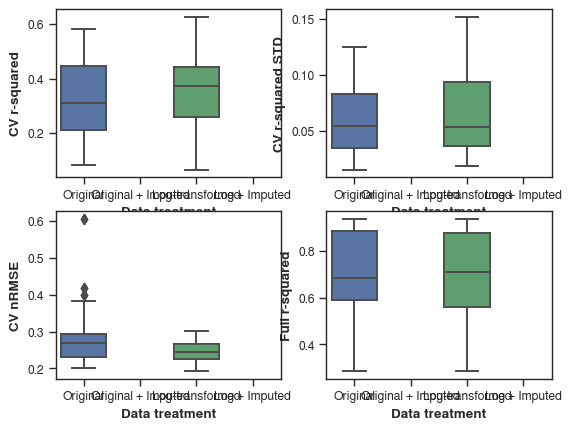

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()

models = ["Original", "Original + Imputed", "Log-transformed", "Log + Imputed"]
metrics = ["CV r-squared", "CV r-squared STD", "CV nRMSE", "Full r-squared"]

for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        ax = axs[i]
        sns.boxplot(x="Run type", y=metric, data=results, order=models, ax=ax)
        # data = results[results["Run ID"] == model][metric]
        # sns.boxplot(data=data, ax=ax)
        ax.set(xlabel="Data treatment", label=metric)
        ax.set_xlabel(ax.get_xlabel(), fontweight="bold")
        ax.set_ylabel(ax.get_ylabel(), fontweight="bold")

plt.show()

After dropping outlier models from the log-transformed suite of models, the log-transformed models appear to perform best in terms of CV R^2 and Overall R^2 and with a generally lower CV nRMSE, but greater variance in its CV R^2 standard deviation. This makes sense, as many of the untransformed traits were already normally distributed, and so log-transforming them would likley result in poorer model fitting.

In general, it appears that there is not a big difference between predictor datasets with missing values and imputed datasets, though the CV R^2 STD does increase slightly for models trained on non-imputed datasets.

**Now let's isolate the best performing models for each trait**

In [7]:
# First filter out rows that contain "imputed" in the Run ID column
results_mvs = results[~results["Run type"].str.contains("Imputed")]

# Only select rows with Run ID "2023-09-23_13-30-09" or "2023-09-23_11-44-08"
results_mvs = results_mvs[
    results_mvs["Run ID"].isin(["2023-09-23_13-30-09", "2023-09-23_11-44-08"])
]

# Next split results into GBIF and sPlot dataframes
results_gbif = results_mvs[results_mvs["Response variable"].str.contains("GBIF")]
results_splot = results_mvs[results_mvs["Response variable"].str.contains("sPlot")]

# Next create empty dataframes (one for GBIF and one for sPlot) with the same column names as the results dataframe
# Then, for each trait, get the row with the highest CV r-squared and append it to the empty dataframe
# This will give us the best model for each trait

best_models_gbif = pd.DataFrame(
    columns=results_gbif.columns.values,
    # index=range(len(mapping)),
)
best_models_splot = pd.DataFrame(
    columns=results_splot.columns.values,
    # index=range(len(mapping)),
)

for i, (trait_id, trait) in enumerate(mapping.items()):
    best_gbif_row = (
        results_gbif[results_gbif["Response variable"].str.contains(f"_X{trait_id}_")]
        .sort_values(by=["CV r-squared"], ascending=False)
        .iloc[0]
    )
    best_models_gbif = pd.concat([best_models_gbif, best_gbif_row.to_frame().T])

    # The best GBIF run types don't necessarily correspond to the best sPlot run types
    # for the same traits, but for an apples-to-apples comparison we should use the same
    # run types for both datasets
    best_gbif_trait = best_gbif_row["Response variable"].split("GBIF_")[1]

    best_splot_row = (
        results_splot[results_splot["Response variable"] == f"sPlot_{best_gbif_trait}"]
        .sort_values(by=["CV r-squared"], ascending=False)
        .iloc[0]
    )

    best_models_splot = pd.concat([best_models_splot, best_splot_row.to_frame().T])

best_models_gbif = best_models_gbif.sort_values(by=["CV r-squared"], ascending=False)
best_models_splot = best_models_splot.sort_values(by=["CV r-squared"], ascending=False)

In [8]:
def best_models_printable(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare the best models dataframe for printing in LaTeX"""
    df = df.drop(columns=["Run ID", "Response variable"])
    # Set numeric columns to float
    df = df.astype(
        {
            "N observations": int,
            "CV nRMSE": float,
            "CV nRMSE STD": float,
            "CV r-squared": float,
            "CV r-squared STD": float,
            "Full r-squared": float,
        }
    ).round(2)

    # append "(n = {N observations})" to Trait name values
    df["Trait name"] = (
        df["Trait name"].astype(str) + " (n=" + df["N observations"].astype(str) + ")"
    )

    # append "±{CV nRMSE STD}" to "CV nRMSE" values (do the same for CV r-squared)
    df["CV nRMSE"] = df["CV nRMSE"].astype(str) + " ±" + df["CV nRMSE STD"].astype(str)
    df["CV r-squared"] = (
        df["CV r-squared"].astype(str) + " ±" + df["CV r-squared STD"].astype(str)
    )

    df = df.drop(columns=["N observations", "CV nRMSE STD", "CV r-squared STD"])

    return df

In [9]:
print(best_models_printable(best_models_gbif).to_markdown(index=False, floatfmt=".2f"))

| Run type        | Trait name                                     | CV nRMSE   | CV r-squared   |   Full r-squared |
|:----------------|:-----------------------------------------------|:-----------|:---------------|-----------------:|
| Log-transformed | Stem conduit density (n=33043)                 | 0.21 ±0.01 | 0.53 ±0.03     |             0.73 |
| Log-transformed | Seed dry mass (n=33155)                        | 0.23 ±0.01 | 0.45 ±0.02     |             0.69 |
| Original        | Leaf delta 15N (n=35116)                       | 0.24 ±0.01 | 0.45 ±0.04     |             0.69 |
| Log-transformed | Root rooting depth (n=33163)                   | 0.24 ±0.01 | 0.44 ±0.04     |             0.69 |
| Log-transformed | Leaf area (3112) (n=33166)                     | 0.24 ±0.01 | 0.39 ±0.04     |             0.63 |
| Log-transformed | Leaf fresh mass (n=33195)                      | 0.24 ±0.01 | 0.37 ±0.03     |             0.65 |
| Log-transformed | Seed length (n=33176)               

In [10]:
print(best_models_printable(best_models_splot).to_markdown(index=False, floatfmt=".2f"))

| Run type        | Trait name                                    | CV nRMSE   | CV r-squared   |   Full r-squared |
|:----------------|:----------------------------------------------|:-----------|:---------------|-----------------:|
| Log-transformed | Root rooting depth (n=4985)                   | 0.19 ±0.02 | 0.63 ±0.07     |             0.94 |
| Original        | SSD (n=5307)                                  | 0.2 ±0.01  | 0.58 ±0.06     |             0.93 |
| Log-transformed | Stem conduit density (n=5009)                 | 0.2 ±0.02  | 0.57 ±0.08     |             0.88 |
| Original        | SLA (n=5322)                                  | 0.21 ±0.02 | 0.53 ±0.09     |             0.91 |
| Log-transformed | Leaf N per area (n=4958)                      | 0.21 ±0.01 | 0.52 ±0.1      |             0.93 |
| Log-transformed | Leaf area (3112) (n=5003)                     | 0.2 ±0.01  | 0.51 ±0.08     |             0.88 |
| Log-transformed | Leaf area (3114) (n=5005)                   

Figure with scatterplots of CV-predictions vs observed for each of a subset of traits, along with R

In [82]:
results_dir = Path("results/training")
# Create a list of tuples of Run ID and Response variable for each row in best_models_gbif and best_models_splot
# This will be used to filter out the results dataframes to only include the best model for each trait
gbif_id_rvs = list(
    zip(best_models_gbif["Run ID"], best_models_gbif["Response variable"])
)
splot_id_rvs = list(
    zip(best_models_splot["Run ID"], best_models_splot["Response variable"])
)

gbif_trait_dirs = [Path(results_dir / run_id / f"GBIF_{rv}") for run_id, rv in gbif_id_rvs]
splot_trait_dirs = [Path(results_dir / run_id / f"sPlot_{rv}") for run_id, rv in splot_id_rvs]

# get select traits (50, 14, 11)
select_traits = [169, 4, 50, 14, 11]
gbif_select_dirs = []
splot_select_dirs = []
for trait_dir in gbif_trait_dirs:
    trait_id = trait_dir.name.split("_X")[1].split("_")[0]
    if int(trait_id) in select_traits:
        gbif_select_dirs.append(trait_dir)

for trait_dir in splot_trait_dirs:
    trait_id = trait_dir.name.split("_X")[1].split("_")[0]
    if int(trait_id) in select_traits:
        splot_select_dirs.append(trait_dir)

gbif_select_dirs = sorted(gbif_select_dirs)
splot_select_dirs = sorted(splot_select_dirs)

In [75]:
from typing import Any, Tuple


def plot_observed_vs_predicted(
    ax: plt.Axes,
    observed: pd.Series,
    predicted: pd.Series,
    name: str,
    log: bool = False,
    density: bool = False,
    show_r: bool = True,
    context: Any = "talk",
):
    """Plot observed vs. predicted values."""
    sns.set_context(context)

    p1 = min(predicted.min(), observed.min())
    p2 = max(predicted.max(), observed.max())

    cmap = sns.cubehelix_palette(start=0.5, rot=-0.75, reverse=True, as_cmap=True)  # type: ignore
    if density:
        sns.kdeplot(x=predicted, y=observed, ax=ax, cmap=cmap, fill=True, thresh=0.0075)
    else:
        sns.scatterplot(x=predicted, y=observed, ax=ax, s=1)

    # Fit a regression line for observed vs. predicted values, plot the regression
    # line so that it spans the entire plot, and print the correlation coefficient
    m, b = np.polyfit(predicted, observed, 1)
    reg_line = [m * p1 + b, m * p2 + b]

    midline_params = {
        "color": "black",
        "ls": "-.",
        "lw": 0.5,
        "alpha": 0.5,
    }

    regline_params = {"color": "red", "lw": 0.5}
    if log:
        ax.loglog([p1, p2], [p1, p2], **midline_params)
        ax.loglog([p1, p2], reg_line, **regline_params)
    else:
        ax.plot([p1, p2], [p1, p2], **midline_params)
        ax.plot([p1, p2], reg_line, **regline_params)

    # make sure lines are positioned on top of kdeplot
    ax.set_zorder(1)

    buffer_color = "white"

    text_params = {
        "transform": ax.transAxes,
        "ha": "left",
        "va": "top",
        "bbox": {"facecolor": buffer_color, "edgecolor": buffer_color, "pad": 0.5},
    }

    if show_r:
        ax.text(
            0.05,
            0.95,
            f"$r$ = {np.corrcoef(predicted, observed)[0, 1]:.3f}",
            **text_params,
        )

    ax.text(0.05, 0.90, f"n = {len(predicted):,}", **text_params)

    # include legend items for the reg_line and the 1-to-1 line
    ax.legend(
        [
            ax.get_lines()[0],
            ax.get_lines()[1],
        ],
        ["1-to-1", "Regression"],
        loc="lower right",
        frameon=False,
    )

    # set informative axes and title
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Observed")
    ax.set_title(name)

    return ax


import matplotlib.gridspec as gridspec


def subplots_centered(nrows, ncols, figsize, nfigs):
    """
    Modification of matplotlib plt.subplots(),
    useful when some subplots are empty.

    It returns a grid where the plots
    in the **last** row are centered.

    Inputs
    ------
        nrows, ncols, figsize: same as plt.subplots()
        nfigs: real number of figures
    """
    assert nfigs < nrows * ncols, "No empty subplots, use normal plt.subplots() instead"

    fig = plt.figure(figsize=figsize)
    axs = []

    m = nfigs % ncols
    m = range(1, ncols + 1)[-m]  # subdivision of columns
    gs = gridspec.GridSpec(nrows, m * ncols)

    for i in range(0, nfigs):
        row = i // ncols
        col = i % ncols

        if row == nrows - 1:  # center only last row
            off = int(m * (ncols - nfigs % ncols) / 2)
        else:
            off = 0

        ax = plt.subplot(gs[row, m * col + off : m * (col + 1) + off])
        axs.append(ax)

    return fig, np.asarray(axs)


def plot_all_trait_obs_pred(
    trait_dirs,
    mapping=None,
    ncols: int = 5,
    density: bool = False,
    context: Any = "paper",
):
    """Plot observed vs. predicted values for all traits in the given list of trait directories."""
    ntraits = len(trait_dirs)
    nrows = int(np.ceil(ntraits / ncols))

    _, axs = subplots_centered(
        nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows), nfigs=ntraits
    )
    # fig, axs = plt.subplots(
    #     nrows=nrows,
    #     ncols=ncols,
    #     figsize=(20, 5 * nrows),
    #     tight_layout=True,
    #     # dpi=200,
    # )
    
    axs = axs.flatten()

    for i, trait_dir in enumerate(trait_dirs):
        trait = trait_dir.stem

        log = trait.endswith("_ln")

        if mapping:
            # Update trait name to match the mapping
            trait_id = trait.split("_X")[1].split("_")[0]
            trait_set = trait.split("_")[0]
            trait = f"{trait_set} {mapping[trait_id]['short']}"
            if log:
                trait += " (log)"

        obs_vs_pred = pd.read_parquet(trait_dir / "cv_predictions.parq")

        obs = obs_vs_pred["observed"]
        pred = obs_vs_pred["predicted"]

        axs[i] = plot_observed_vs_predicted(
            axs[i], obs, pred, trait, density=density, show_r=False, context=context
        )

        # Plot CV R with STD instead of simple r
        r_mean, r_std = cv_r(obs_vs_pred)
        axs[i].text(
            0.05,
            0.95,
            f"$r$ = {r_mean:.2f}±{r_std:.2f}",
            transform=axs[i].transAxes,
            ha="left",
            va="top",
            bbox={"facecolor": "white", "edgecolor": "white", "pad": 0.5},
        )

    # Ensure that only the left-most column has y-axis labels
    for i in range(ntraits):
        if i % ncols != 0:
            axs[i].set_ylabel("")

    plt.tight_layout()
    sns.despine()


def cv_r(df: pd.DataFrame) -> Tuple[float, float]:
    """Calculate the mean and standard deviation of the correlation coefficient for each
    fold in the given dataframe"""
    grouped = df.groupby("fold").apply(lambda x: x["observed"].corr(x["predicted"]))
    return (grouped.mean(), grouped.std())

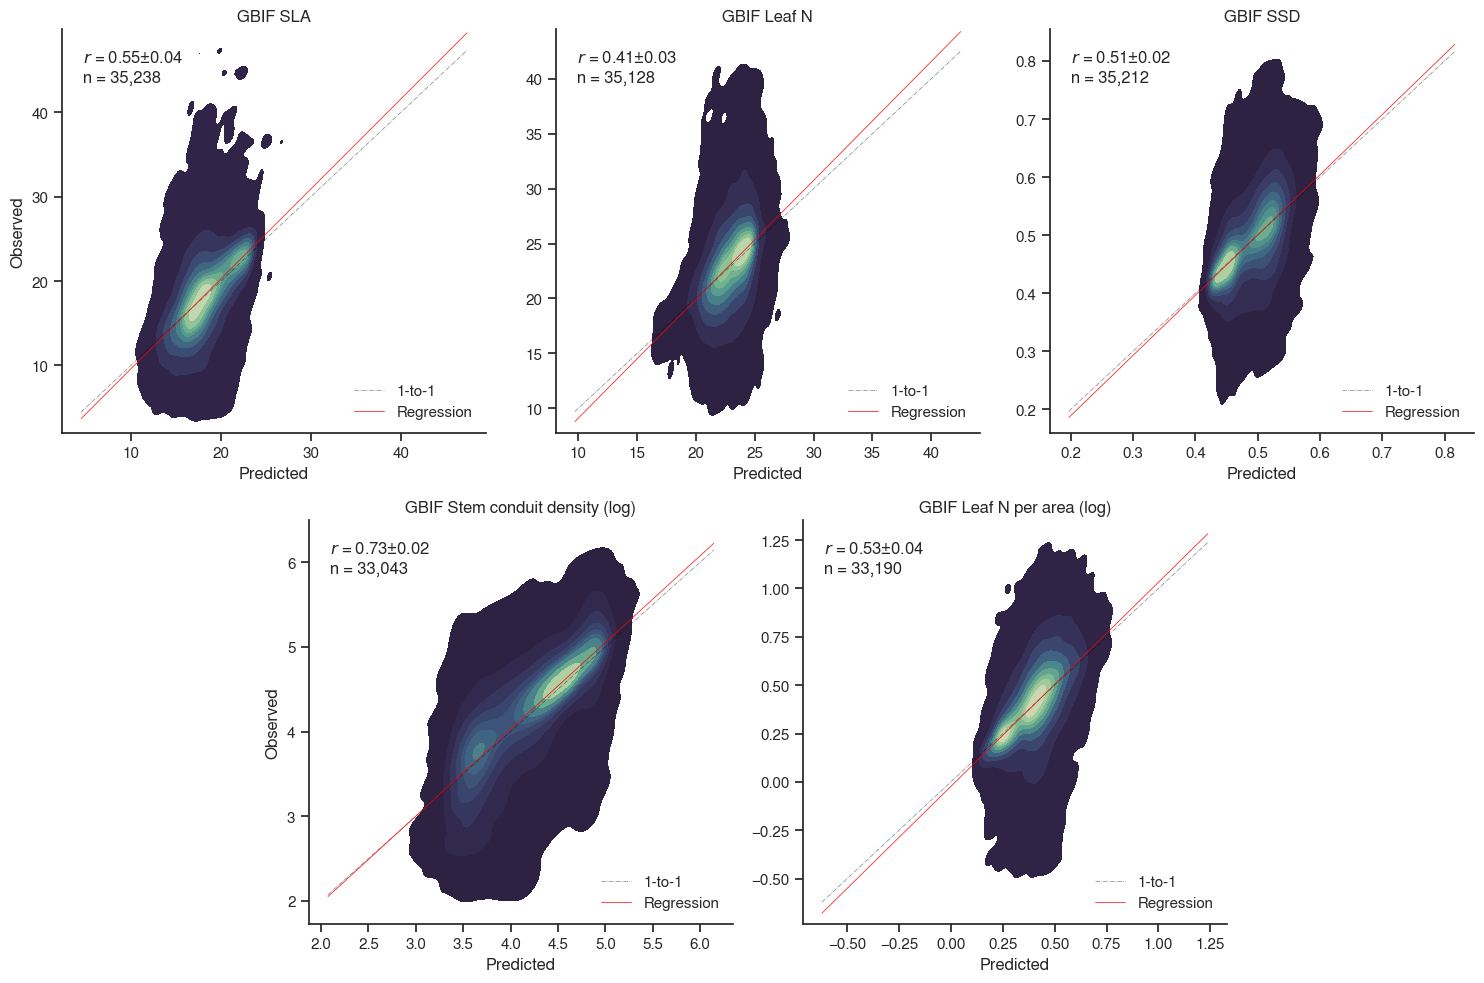

In [83]:
# plot_all_trait_obs_pred(gbif_trait_dirs, mapping, density=True, context="notebook")
plot_all_trait_obs_pred(gbif_select_dirs, mapping, ncols=3, density=True, context="notebook")

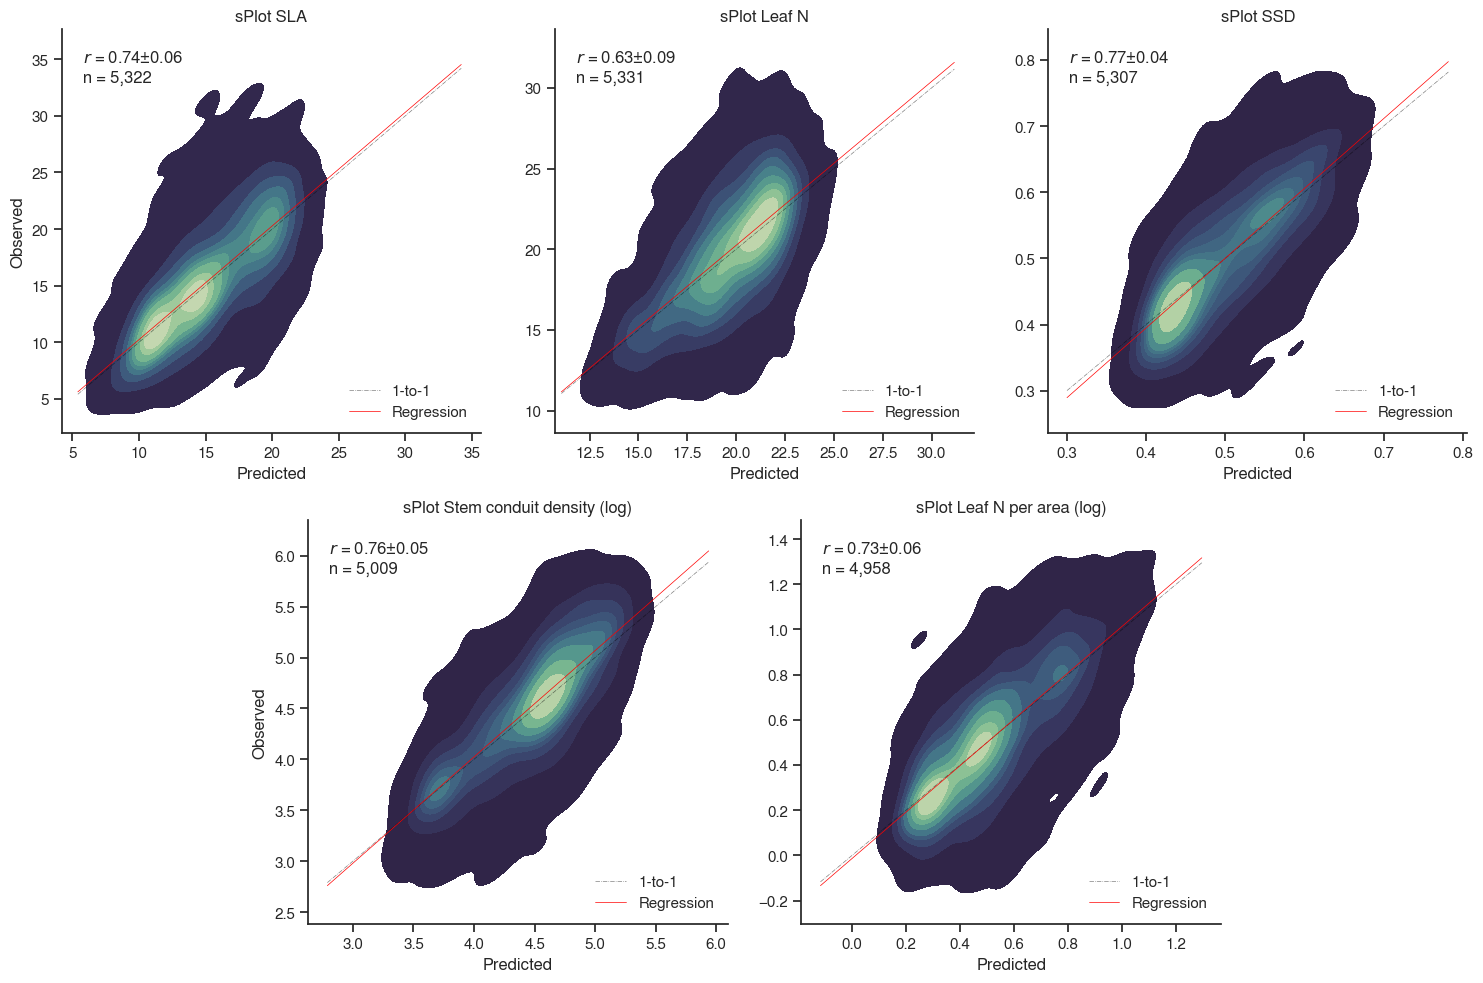

In [84]:
# plot_all_trait_obs_pred(splot_trait_dirs, mapping, density=True, context="notebook")
plot_all_trait_obs_pred(splot_select_dirs, mapping, ncols=3, density=True, context="notebook")

## Crowd-sourced vs sPlotOpen

Figure: Box plot of GBIF and sPlot CV-R2 (y-axis) for each trait (x-axis). I.e. two boxes for each trait, one for GBIF and one for sPlot. Could print RMSE ± STD for each one, too?

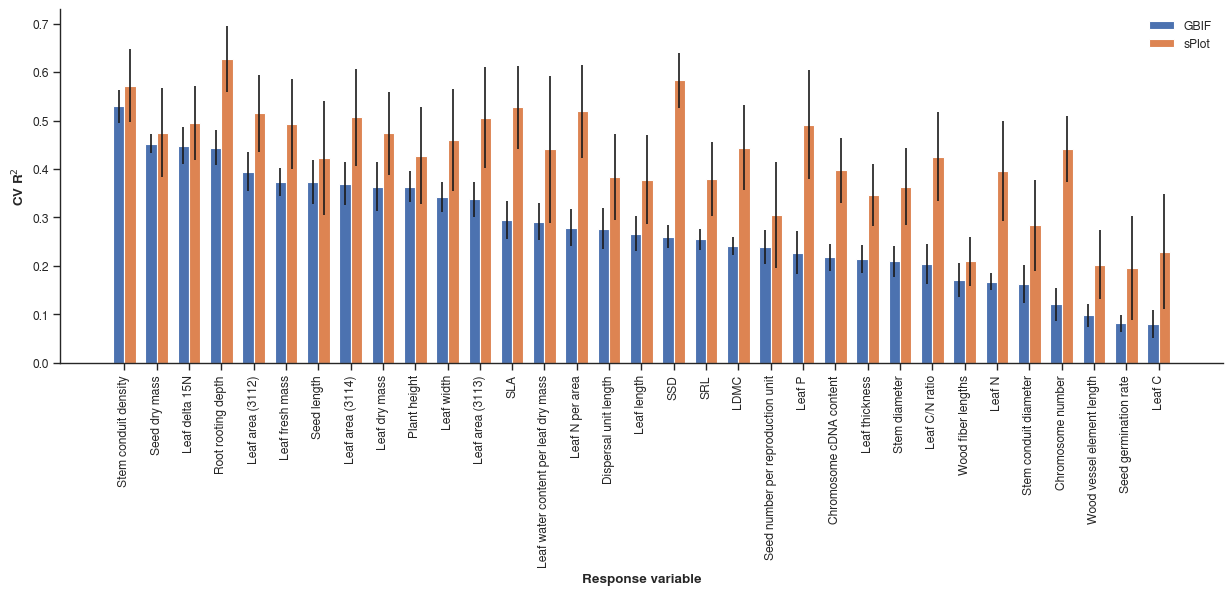

In [183]:
best_models_gbif = best_models_gbif.sort_values(by=["CV r-squared"], ascending=False)
best_models_splot = best_models_splot.sort_values(by=["CV r-squared"], ascending=False)

# For each matching Response variable in best_models_gbif and best_models_splot, plot
# the CV r-squared values as a bar chart, with the corresponding CV r-squared STD representing the error bars

# First, drop the GBIF_ and sPlot_ prefixes from the Response variable column
best_models_gbif["Response variable"] = best_models_gbif[
    "Response variable"
].str.replace("GBIF_", "")
best_models_splot["Response variable"] = best_models_splot[
    "Response variable"
].str.replace("sPlot_", "")

# Then, merge the two dataframes on Response variable
best_models_gbif_splot = pd.merge(
    best_models_gbif,
    best_models_splot,
    on="Response variable",
    suffixes=("_gbif", "_splot"),
)

x_labels = best_models_gbif_splot["Trait name_gbif"]
bar_width = 0.35
x_pos = [i for i in range(len(x_labels))]

# plot the GBIF CV r-squared values as bars
gbif_r2 = best_models_gbif_splot["CV r-squared_gbif"]
gbif_std = best_models_gbif_splot["CV r-squared STD_gbif"]
plt.bar(x_pos, gbif_r2, width=bar_width, yerr=gbif_std, label="GBIF")

# plot the sPlot CV r-squared values as bars
splot_r2 = best_models_gbif_splot["CV r-squared_splot"]
splot_std = best_models_gbif_splot["CV r-squared STD_splot"]
plt.bar(
    [i + bar_width for i in x_pos],
    splot_r2,
    width=bar_width,
    yerr=splot_std,
    label="sPlot",
)

# set the x-axis labels and title
plt.xlabel("Response variable", weight="bold")
plt.ylabel("CV R$^2$", weight="bold")

sns.despine()
sns.set_context("paper")
ax = plt.gca()
ax.set_aspect(15)

fig = plt.gcf()
fig.set_figheight(15)
fig.set_figwidth(15)

# set the x-axis tick positions and labels
plt.xticks([i + bar_width / 2 for i in x_pos], x_labels, rotation=90)
plt.legend(edgecolor="white")
# plt.savefig(fig_dir / "splot-gbif-cvr2.pdf", bbox_inches="tight")
plt.show()

Table (or bar chart) showing global cover % for GBIF vs sPlotOpen traits (should include CV R2 for each model, too, since GBIF generally has lower R2.

In [133]:
from typing import Union
from pathlib import Path

import dask.dataframe as dd
import pandas as pd
from utils.geodata import get_trait_name_from_data_name
from tqdm.notebook import tqdm


# predict_name = "MOD09GA.061_ISRIC_soil_WC_BIO_VODCA_0.5_deg_nan-strat=any_thr=0.5"


def single_res_aoa_table(
    resolution: Union[int, float] = 0.5,
    pft: str = "Shrub_Tree_Grass",
) -> pd.DataFrame:
    """Create a table of AOA values for each trait at a given resolution and PFT"""
    use_dask = False

    if resolution == 0.01:
        predict_name = "tiled_5x5_deg_MOD09GA.061_ISRIC_soil_WC_BIO_VODCA_0.01_deg_nan-strat=any_thr=0.5"
        use_dask = True
    else:
        predict_name = f"MOD09GA.061_ISRIC_soil_WC_BIO_VODCA_{resolution:g}_deg_nan-strat=any_thr=0.5"

    predicted_traits = list(
        Path(f"results/predictions/05deg_models/{predict_name}/{pft}").glob("*")
    )

    aoa_df = pd.DataFrame(
        columns=["GBIF AOA", "sPlot AOA", "Pct change"],
    )

    for trait in tqdm(predicted_traits):
        if not trait.is_dir():
            continue
        gbif_fn = list(Path(trait, "GBIF").glob("*.parq"))[0]
        splot_fn = list(Path(trait, "sPlot").glob("*.parq"))[0]

        if use_dask:
            columns = dd.read_parquet(gbif_fn).columns.values
            if "AOA" not in columns:
                continue
            else:
                gbif_trait_df = dd.read_parquet(gbif_fn, columns=["AOA"])
                splot_trait_df = dd.read_parquet(splot_fn, columns=["AOA"])
        else:
            columns = pd.read_parquet(gbif_fn).columns.values
            if "AOA" not in columns:
                continue
            else:
                gbif_trait_df = pd.read_parquet(gbif_fn, columns=["AOA"])
                splot_trait_df = pd.read_parquet(splot_fn, columns=["AOA"])

        # For each trait, add a new row to aoa_df with the response variable, GBIF AOA, and sPlot AOA

        gbif_aoa = gbif_trait_df["AOA"].sum() / gbif_trait_df["AOA"].count()
        splot_aoa = splot_trait_df["AOA"].sum() / splot_trait_df["AOA"].count()

        gbif_aoa = gbif_aoa.compute() if use_dask else gbif_aoa
        splot_aoa = splot_aoa.compute() if use_dask else splot_aoa

        new_row = [gbif_aoa * 100, splot_aoa * 100, (gbif_aoa - splot_aoa) * 100]

        trait_name = get_trait_name_from_data_name(trait.name, short=True)
        aoa_df.loc[trait_name] = new_row

    aoa_df = aoa_df.dropna().astype(float).sort_values(by="Pct change", ascending=False)

    return aoa_df


aoa_05 = single_res_aoa_table(resolution=0.5)
aoa_2 = single_res_aoa_table(resolution=2)
aoa_02 = single_res_aoa_table(resolution=0.2)
# aoa_001 = single_res_aoa_table(resolution=0.01)

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

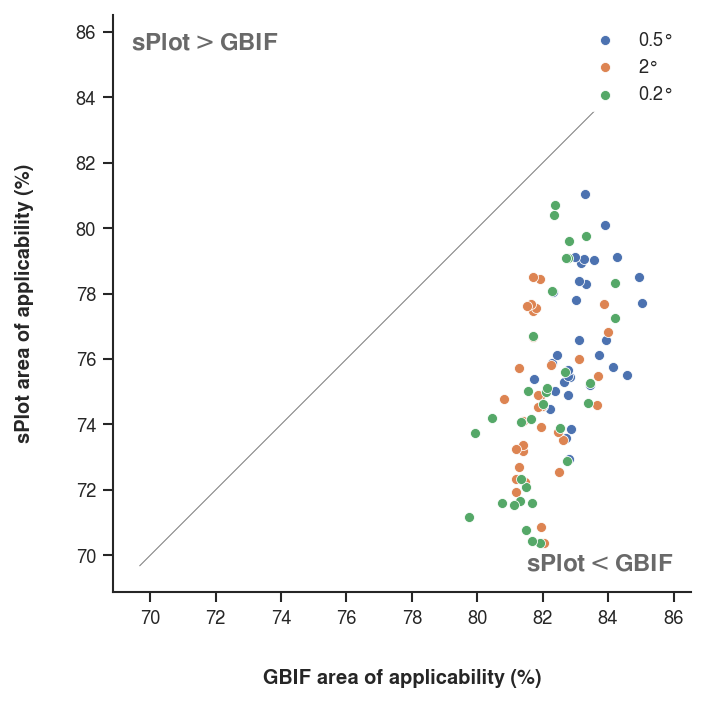

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

_, ax = plt.subplots()

dfs = [aoa_05, aoa_2, aoa_02]
labels = [
    "0.5°",
    "2°",
    "0.2°",
]

min_val = min([min(*df[["GBIF AOA", "sPlot AOA"]].min()) for df in dfs]) - 1
max_val = max([max(*df[["GBIF AOA", "sPlot AOA"]].max()) for df in dfs]) + 1


for df, label in zip(dfs, labels):
    sns.scatterplot(x=df["GBIF AOA"], y=df["sPlot AOA"], ax=ax, label=label)

label_kwargs = {"weight": "bold", "labelpad": 20}
ax.set_xlabel("GBIF area of applicability (%)", **label_kwargs)
ax.set_ylabel("sPlot area of applicability (%)", **label_kwargs)

line_shift = 0.3
# plot 1-1 line
ax.plot(
    [min_val + line_shift, max_val - line_shift],
    [min_val + line_shift, max_val - line_shift],
    color="grey",
    linestyle="-",
    lw=0.5,
)

text_shift = 0.03

quadrant_label_kwargs = {
    "color": "dimgrey",
    "fontweight": "bold",
    "fontsize": "large",
    "transform": ax.transAxes,
}

ax.text(
    text_shift,
    1 - text_shift,
    horizontalalignment="left",
    verticalalignment="top",
    s="sPlot$>$GBIF",
    **quadrant_label_kwargs,
)

ax.text(
    1 - text_shift,
    text_shift,
    horizontalalignment="right",
    verticalalignment="bottom",
    s="sPlot$<$GBIF",
    **quadrant_label_kwargs,
)

ax.legend(
    loc="upper right", facecolor="white", edgecolor="white", framealpha=1
)  # , bbox_to_anchor=(0.05, 0.85))

sns.set_context("paper")
sns.despine()
ax.set_aspect("equal")
side_size = 5
fig = plt.gcf()
fig.set_figheight(side_size)
fig.set_figwidth(side_size)
fig.set_dpi(150)
plt.savefig(fig_dir / "gbif-vs-splot-aoa.pdf", bbox_inches="tight")

In [93]:
# columns = ["Pct change 2 deg", "Pct change 0.5 deg", "Pct change 0.2 deg", "Pct change 0.01 deg"]
columns = ["Pct change 2 deg", "Pct change 0.5 deg", "Pct change 0.2 deg"]
aoa_all = pd.DataFrame(columns=columns)
aoa_all["Pct change 2 deg"] = aoa_2["Pct change"]
aoa_all["Pct change 0.5 deg"] = aoa_05["Pct change"]
aoa_all["Pct change 0.2 deg"] = aoa_02["Pct change"]
# aoa_all["Pct change 0.01 deg"] = aoa_001["Pct change"]

aoa_all = aoa_all.sort_index()

# add median, mean, and std rows to summarize each column
aoa_all.loc["Median"] = aoa_all.median()
aoa_all.loc["Mean"] = aoa_all.mean()
aoa_all.loc["STD"] = aoa_all.std()

print(aoa_all.round(2).fillna("-").to_markdown())

|                                      |   Pct change 2 deg |   Pct change 0.5 deg |   Pct change 0.2 deg |
|:-------------------------------------|-------------------:|---------------------:|---------------------:|
| Chromosome cDNA content              |               7.41 |                 7.88 |                 7.49 |
| Chromosome number                    |               8.56 |                 7.27 |                 9.58 |
| Dispersal unit length                |               9.05 |                 8.41 |                 8.15 |
| LDMC                                 |               9.95 |                 8.25 |                11.55 |
| Leaf C                               |               7.32 |                 4.71 |                 7.03 |
| Leaf C/N ratio                       |               7.07 |                 4.26 |                 6.24 |
| Leaf N                               |               8.84 |                 6.31 |                 9.14 |
| Leaf N per area           

## Global trait maps visualization

Figure of global trait maps for selected traits with two columns—left column containing trait predictions masked by AoA, right column containing trait prediction CoV (also masked by AoA?)

First, back-transform trait values predicted by models trained in log-space.

In [ ]:
for i, (gbif, splot) in enumerate(zip(gbif_predictions, splot_predictions)):
    if gbif.columns[0].endswith("_ln"):
        # back-transform columns 0 and 4
        gbif.iloc[:, 0] = np.exp(gbif.iloc[:, 0])
        gbif.iloc[:, 4] = np.exp(gbif.iloc[:, 4])

    if splot.columns[0].endswith("_ln"):
        # back-transform columns 0 and 4
        splot.iloc[:, 0] = np.exp(splot.iloc[:, 0])
        splot.iloc[:, 4] = np.exp(splot.iloc[:, 4])

    # rename columns 0 and 4 by replacing "_ln" with nothing
    gbif = gbif.rename(columns={gbif.columns[0]: gbif.columns[0].replace("_ln", "")})
    gbif = gbif.rename(columns={gbif.columns[4]: gbif.columns[4].replace("_ln", "")})

    splot = splot.rename(
        columns={splot.columns[0]: splot.columns[0].replace("_ln", "")}
    )
    splot = splot.rename(
        columns={splot.columns[4]: splot.columns[4].replace("_ln", "")}
    )

    gbif_predictions[i] = gbif
    splot_predictions[i] = splot

In [ ]:
for i, (gbif, splot) in enumerate(zip(gbif_predictions, splot_predictions)):
    gbif_predictions[i] = make_geocube(vector_data=gbif, resolution=(-0.5, 0.5))
    gbif_predictions[i] = pad_ds(gbif_predictions[i])

    splot_predictions[i] = make_geocube(vector_data=splot, resolution=(-0.5, 0.5))
    splot_predictions[i] = pad_ds(splot_predictions[i])

In [ ]:
plot_pred_cov(gbif_predictions)

Figure (appendix): All remaining global trait maps with > R2-THRESHOLD

## Feature importances

Filter models with a CV r^2 below 0.2

In [85]:
pi_gbif = PI.loc[best_models_gbif[best_models_gbif["CV r-squared"] > 0.2].index]
pi_splot = PI.loc[best_models_splot[best_models_splot["CV r-squared"] > 0.2].index]

In [86]:
def ds_importance(PIs):
    PIs = ast.literal_eval(PIs)

    ds_keys = {
        "MODIS": ["sur_refl"],
        "WorldClim": ["wc2.1"],
        "Soil": [
            "0-5cm",
            "0-30cm",
            "5-15cm",
            "15-30cm",
            "30-60cm",
            "60-100cm",
            "100-200cm",
        ],
        "VODCA": ["C_2", "Ku_2", "X_2"],
    }

    # Get the average and standard deviation of the predictor importance values for each dataset
    PIs = {k: [np.mean(v), np.std(v)] for k, v in PIs.items()}

    ds_importance = {}

    for ds, keys in ds_keys.items():
        for feature, imp in PIs.items():
            for key in keys:
                if key in feature:
                    if ds not in ds_importance:
                        ds_importance[ds] = []
                    ds_importance[ds].append(imp)

    return ds_importance

In [87]:
# Get DS importance for each response variable in PI_orig_gbif and PI_orig_splot
pi_gbif["DS importance"] = pi_gbif["CV predictor importance"].apply(ds_importance)
pi_splot["DS importance"] = pi_splot["CV predictor importance"].apply(ds_importance)

Figure: box and whisker plot of predictor datasets (x-axis) and their average importances across all traits for which models had a > R2-THRESHOLD score.

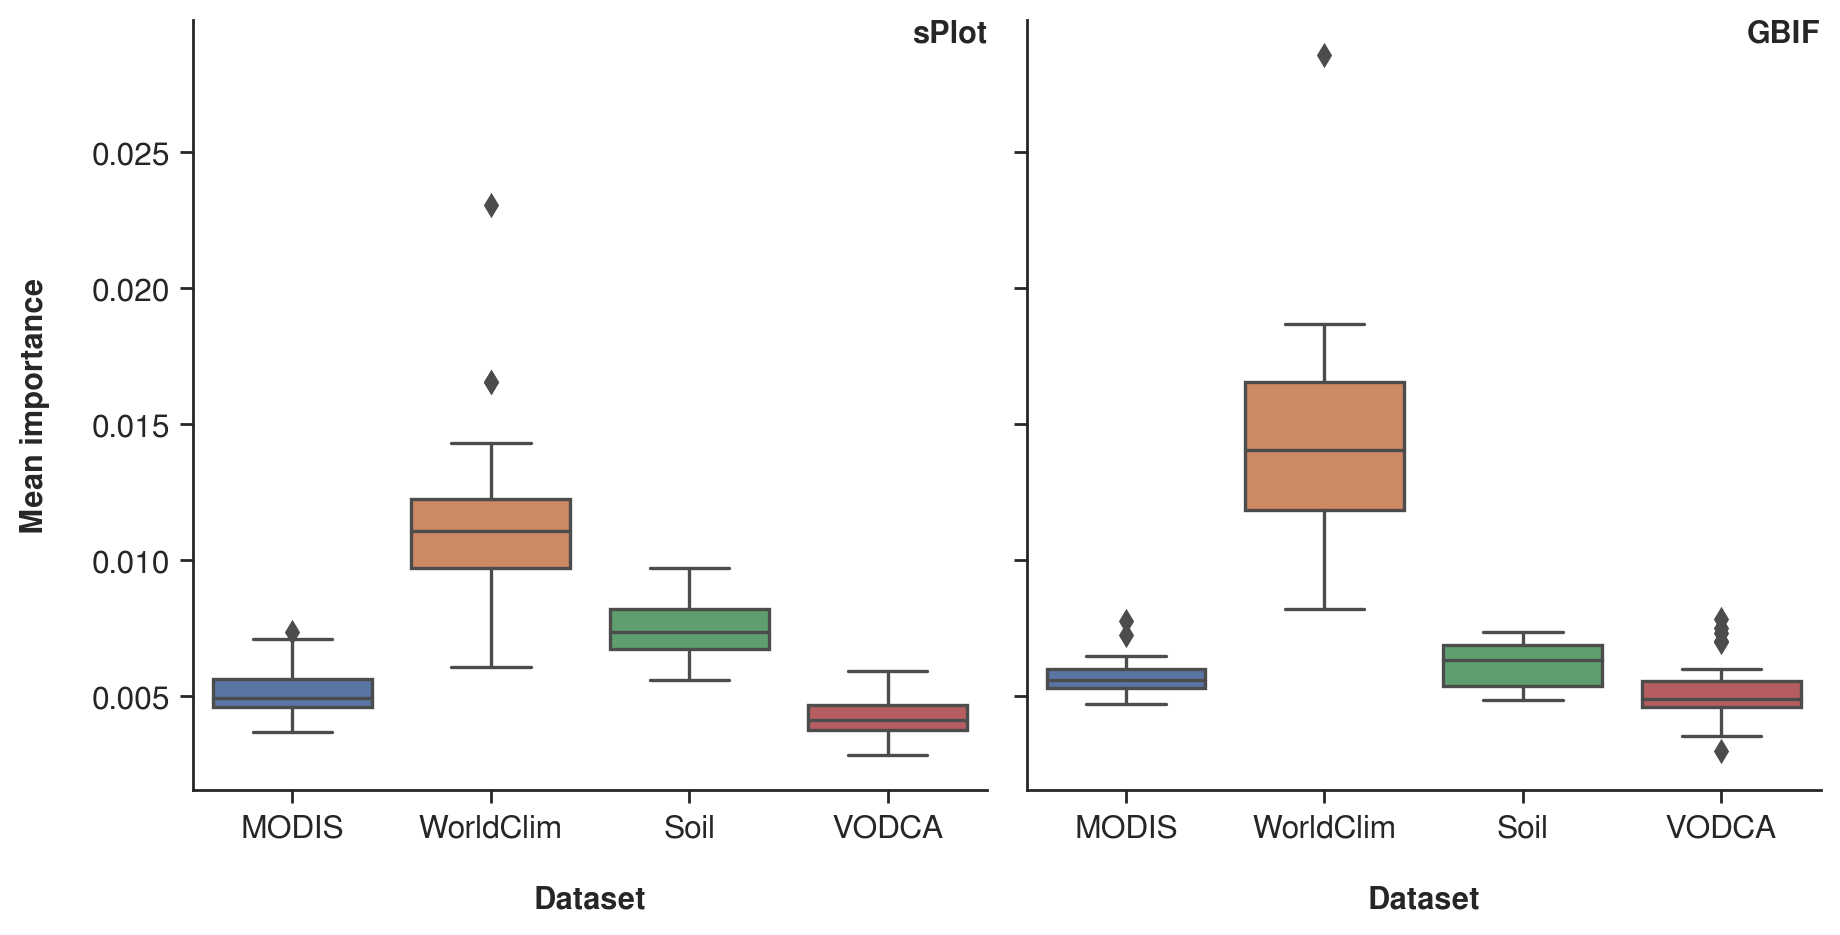

In [130]:
# create a list of dataframes for each dataset for GBIF
dfs_gbif = []
for ds in pi_gbif["DS importance"].iloc[0].keys():
    df = pd.DataFrame(
        {
            "Dataset": ds,
            "Mean importance": [
                np.asarray(imp[ds])[:, 0].mean() for imp in pi_gbif["DS importance"]
            ],
            "STD importance": [
                np.asarray(imp[ds])[:, 1].mean() for imp in pi_gbif["DS importance"]
            ],
        }
    )
    dfs_gbif.append(df)

# concatenate the dataframes into a single dataframe for GBIF
df_gbif = pd.concat(dfs_gbif)

# create a list of dataframes for each dataset for sPlot
dfs_splot = []
for ds in pi_splot["DS importance"].iloc[0].keys():
    df = pd.DataFrame(
        {
            "Dataset": ds,
            "Mean importance": [
                np.asarray(imp[ds])[:, 0].mean() for imp in pi_splot["DS importance"]
            ],
            "STD importance": [
                np.asarray(imp[ds])[:, 1].mean() for imp in pi_splot["DS importance"]
            ],
        }
    )
    dfs_splot.append(df)

# concatenate the dataframes into a single dataframe for sPlot
df_splot = pd.concat(dfs_splot)

# create the figure and subplots
fig, axs = plt.subplots(1, 2, sharey=True)
splot_ax = axs[0]
gbif_ax = axs[1]

title_kwargs = {
    "fontweight": "bold",
    "fontsize": 11,
    "y": 0.95,
    "loc": "right"
}

label_kwargs = {
    "fontweight": "bold",
    "fontsize": 11,
    "labelpad": 15
}

# plot the GBIF boxplot
sns.boxplot(x="Dataset", y="Mean importance", data=df_splot, ax=splot_ax)
splot_ax.set_xlabel("Dataset", **label_kwargs)
splot_ax.set_ylabel("Mean importance", **label_kwargs)
splot_ax.set_title(
    "sPlot",
    **title_kwargs
)

# plot the sPlot boxplot
sns.boxplot(x="Dataset", y="Mean importance", data=df_gbif, ax=gbif_ax)
gbif_ax.set_xlabel("Dataset", **label_kwargs)
gbif_ax.set_ylabel("")
gbif_ax.set_title(
    "GBIF",
    **title_kwargs
)

# adjust the layout and spacing
# plt.tight_layout()
# aspect = 150
# for ax in axs:
#     ax.set_aspect(aspect)

# Reduce the space in between the axes
plt.subplots_adjust(wspace=0.05)
fig = plt.gcf()

figheight = 5
fig.set_figheight(figheight)
fig.set_figwidth(figheight * 2.1)
fig.set_dpi(200)

# plt.gca().set_aspect("2")
sns.despine()
sns.set_context("paper", font_scale=1.3)
# sns.despine(ax=gbif_ax, left=False)
# Remove gbif_ax y ticks


# show the plot
plt.show()

Figure (appendix): Feature importance of individual predictors across all traits for which models had a > R2-THRESHOLD score.

## Comparison of GBIF (and other products) with sPlotOpen grids

Build the dataframe

In [2]:
import json
from pathlib import Path

import pandas as pd
from utils.geodata import open_raster

prod_02_fns = Path(
    "data/other-products/all-prods_stacks_sla-nit-nita_02D_2023-12-15"
).glob("*.nc")
prod_05_fns = Path(
    "data/other-products/all-prods_stacks_sla-nit-nita_05D_2023-12-15"
).glob("*.nc")
prod_2_fns = Path(
    "data/other-products/all-prods_stacks_sla-nit-nita_2D_2023-12-15"
).glob("*.nc")

# Rioxarray opens single-var netCDFs as DataArrays, so we need to convert them to Datasets
prod_02_deg = [
    open_raster(fn, masked=True).to_dataset(name="Wolf") for fn in prod_02_fns
]
prod_05_deg = [open_raster(fn, masked=True) for fn in prod_05_fns]
prod_2_deg = [open_raster(fn, masked=True) for fn in prod_2_fns]

trait_product_mapping = {
    50: "_nita_",
    14: "_nit_",
    11: "_sla_",
}

product_names = sorted(set([str(dv) for prod in prod_05_deg for dv in prod.data_vars]))

with open("./trait_mapping.json", "r", encoding="utf-8") as f:
    trait_mapping = json.load(f)

traits = [
    trait_mapping[str(trait_id)]["short"] for trait_id in trait_product_mapping.keys()
]

mi_columns = pd.MultiIndex.from_product(
    [traits, ["2", "0.5", "0.2", "0.01"]], names=["Trait", "Resolution"]
)

rows = pd.Index(product_names, name="Product")
product_df = pd.DataFrame(index=rows, columns=mi_columns)

In [4]:
from utils.geodata import ds2gdf, open_raster, num_to_str
from utils.spatial_stats import compare_gdfs

resolutions = ["2", "0.5", "0.2"]

for res in resolutions:
    if res == "2":
        prod_set = prod_2_deg
    elif res == "0.5":
        prod_set = prod_05_deg
    elif res == "0.2":
        prod_set = prod_02_deg

    for i, trait in enumerate(prod_set):
        dv_names = list(trait.data_vars)
        prod_fn = trait[dv_names[0]].encoding["source"]
        for k, v in trait_product_mapping.items():
            if v in prod_fn:
                trait_id = k
                break
        trait_name = trait_mapping[str(trait_id)]["short"]
        # print(trait_name)
        splot = open_raster(
            list(
                Path(
                    "GBIF_trait_maps/global_maps/Shrub_Tree_Grass",
                    f"{num_to_str(float(res))}deg",
                ).glob(f"sPlot*_X{trait_id}_*.grd")
            )[0],
            masked=True,
        ).sel(band=2)
        splot = ds2gdf(splot, f"splot {trait_name}")

        for prod in trait.data_vars:
            gdf = ds2gdf(trait[prod], trait_name)
            corr = compare_gdfs(gdf, splot)
            # print(f"{res}: {corr}")
            product_df.loc[prod, (trait_name, res)] = corr

product_df = product_df.astype(float)
product_df.round(3)

Trait      Leaf N per area                    Leaf N                     \
Resolution               2    0.5    0.2 0.01      2    0.5    0.2 0.01   
Product                                                                   
Bodegom                NaN    NaN    NaN  NaN    NaN    NaN    NaN  NaN   
Boonman              0.541  0.481    NaN  NaN  0.060  0.013    NaN  NaN   
Butler               0.467  0.465    NaN  NaN  0.153  0.174    NaN  NaN   
Dong                 0.493  0.562    NaN  NaN  0.186  0.161    NaN  NaN   
Madani                 NaN    NaN    NaN  NaN    NaN    NaN    NaN  NaN   
Moreno               0.585  0.520    NaN  NaN  0.149  0.200    NaN  NaN   
Schiller             0.690  0.588    NaN  NaN  0.436  0.439    NaN  NaN   
Vallicrosa          -0.006  0.010    NaN  NaN  0.149  0.223    NaN  NaN   
Wolf                 0.567  0.561  0.504  NaN  0.354  0.398  0.344  NaN   

Trait         SLA                    
Resolution      2    0.5   0.2 0.01  
Product                              
Bodegom     0.441  0.451   NaN  NaN  
Boonman     0.458  0.504   NaN  NaN  
Butler      0.226  0.266   NaN  NaN  
Dong        0.320  0.345   NaN  NaN  
Madani      0.161  0.009   NaN  NaN  
Moreno      0.435  0.433   NaN  NaN  
Schiller    0.612  0.599   NaN  NaN  
Vallicrosa    NaN    NaN   NaN  NaN  
Wolf        0.538  0.581  0.55  NaN

#### Now load GBIF and sPlot correlations

See `scripts/splot_correlations.py`

In [173]:
import pandas as pd

%load_ext autoreload
%autoreload 2

corr_table = pd.read_parquet("results/weighted_correlations.parquet")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
corr_table

Resolution                     2                 0.5                 0.2  \
Training data               GBIF     sPlot      GBIF     sPlot      GBIF   
Trait PFT                                                                  
X4    Grass             0.581744  0.752511  0.589704  0.920804  0.396660   
      Shrub-Tree        0.669287  0.871791  0.632475  0.956329  0.578312   
      Shrub-Tree-Grass  0.651105  0.854923  0.674028  0.970044  0.607986   
X6    Grass             0.461884  0.691075  0.538122  0.905054  0.236605   
      Shrub-Tree        0.676712  0.835771  0.704965  0.942813  0.517947   
...                          ...       ...       ...       ...       ...   
X3114 Shrub-Tree        0.779139  0.853419  0.671684  0.911523  0.721412   
      Shrub-Tree-Grass  0.703000  0.824142  0.610165  0.897036  0.688415   
X3120 Grass             0.491484  0.716134  0.551799  0.898065  0.448867   
      Shrub-Tree        0.405353  0.711008  0.392611  0.911089  0.252588   
      Shrub-Tree-Grass  0.498467  0.754595  0.538990  0.930638  0.348472   

Resolution                            0.01            
Training data              sPlot      GBIF     sPlot  
Trait PFT                                             
X4    Grass             0.562191  0.433440  0.516861  
      Shrub-Tree        0.754130  0.602309  0.749729  
      Shrub-Tree-Grass  0.722225  0.614639  0.696924  
X6    Grass             0.344972  0.104339  0.153431  
      Shrub-Tree        0.586419  0.279245  0.306020  
...                          ...       ...       ...  
X3114 Shrub-Tree        0.812801  0.561945  0.664685  
      Shrub-Tree-Grass  0.800615  0.532330  0.646143  
X3120 Grass             0.643688  0.475529  0.569251  
      Shrub-Tree        0.510150  0.139406  0.222810  
      Shrub-Tree-Grass  0.651940  0.247105  0.346726  

[99 rows x 8 columns]

Get only Shrub-Tree-Grass correlations for selected traits

In [8]:
idx = pd.IndexSlice
gbif_splot_corr = corr_table.loc[
    idx[
        [f"X{trait_id}" for trait_id in trait_product_mapping.keys()],
        "Shrub-Tree-Grass",
    ],
    :,
]
gbif_splot_corr.index = gbif_splot_corr.index.droplevel(1)
gbif_splot_corr

Resolution            2                 0.5                 0.2            \
Training data      GBIF     sPlot      GBIF     sPlot      GBIF     sPlot   
Trait                                                                       
X50            0.653592  0.850897  0.661919  0.955867  0.617610  0.740717   
X14            0.478782  0.747941  0.542138  0.936712  0.394003  0.639717   
X11            0.601813  0.802314  0.671176  0.963218  0.463470  0.656132   

Resolution         0.01            
Training data      GBIF     sPlot  
Trait                              
X50            0.496411  0.587461  
X14            0.351942  0.489753  
X11            0.417498  0.552954

In [9]:
for row in gbif_splot_corr.iterrows():
    trait_id = row[0].split("X")[-1]
    trait_name = trait_mapping[trait_id]["short"]
    sub_df = row[1].reset_index()
    for sub_row in sub_df.iterrows():
        res = sub_row[1]["Resolution"]
        train_set = sub_row[1]["Training data"]
        corr = sub_row[1][-1]
        product_df.loc[train_set, (trait_name, res)] = corr

In [10]:
product_df.sort_values(by=[("Leaf N", "0.5")], ascending=False).astype(float).round(
    2
).fillna("-")

Trait      Leaf N per area                   Leaf N                     SLA  \
Resolution               2   0.5   0.2  0.01      2   0.5   0.2  0.01     2   
Product                                                                       
sPlot                 0.85  0.96  0.74  0.59   0.75  0.94  0.64  0.49   0.8   
GBIF                  0.65  0.66  0.62   0.5   0.48  0.54  0.39  0.35   0.6   
Schiller              0.69  0.59     -     -   0.44  0.44     -     -  0.61   
Wolf                  0.57  0.56   0.5     -   0.35   0.4  0.34     -  0.54   
Vallicrosa           -0.01  0.01     -     -   0.15  0.22     -     -     -   
Moreno                0.59  0.52     -     -   0.15   0.2     -     -  0.44   
Butler                0.47  0.47     -     -   0.15  0.17     -     -  0.23   
Dong                  0.49  0.56     -     -   0.19  0.16     -     -  0.32   
Boonman               0.54  0.48     -     -   0.06  0.01     -     -  0.46   
Bodegom                  -     -     -     -      -     -     -     -  0.44   
Madani                   -     -     -     -      -     -     -     -  0.16   

Trait                         
Resolution   0.5   0.2  0.01  
Product                       
sPlot       0.96  0.66  0.55  
GBIF        0.67  0.46  0.42  
Schiller     0.6     -     -  
Wolf        0.58  0.55     -  
Vallicrosa     -     -     -  
Moreno      0.43     -     -  
Butler      0.27     -     -  
Dong        0.34     -     -  
Boonman      0.5     -     -  
Bodegom     0.45     -     -  
Madani      0.01     -     -

#### Shrub-Tree-Grass

Scatter plot

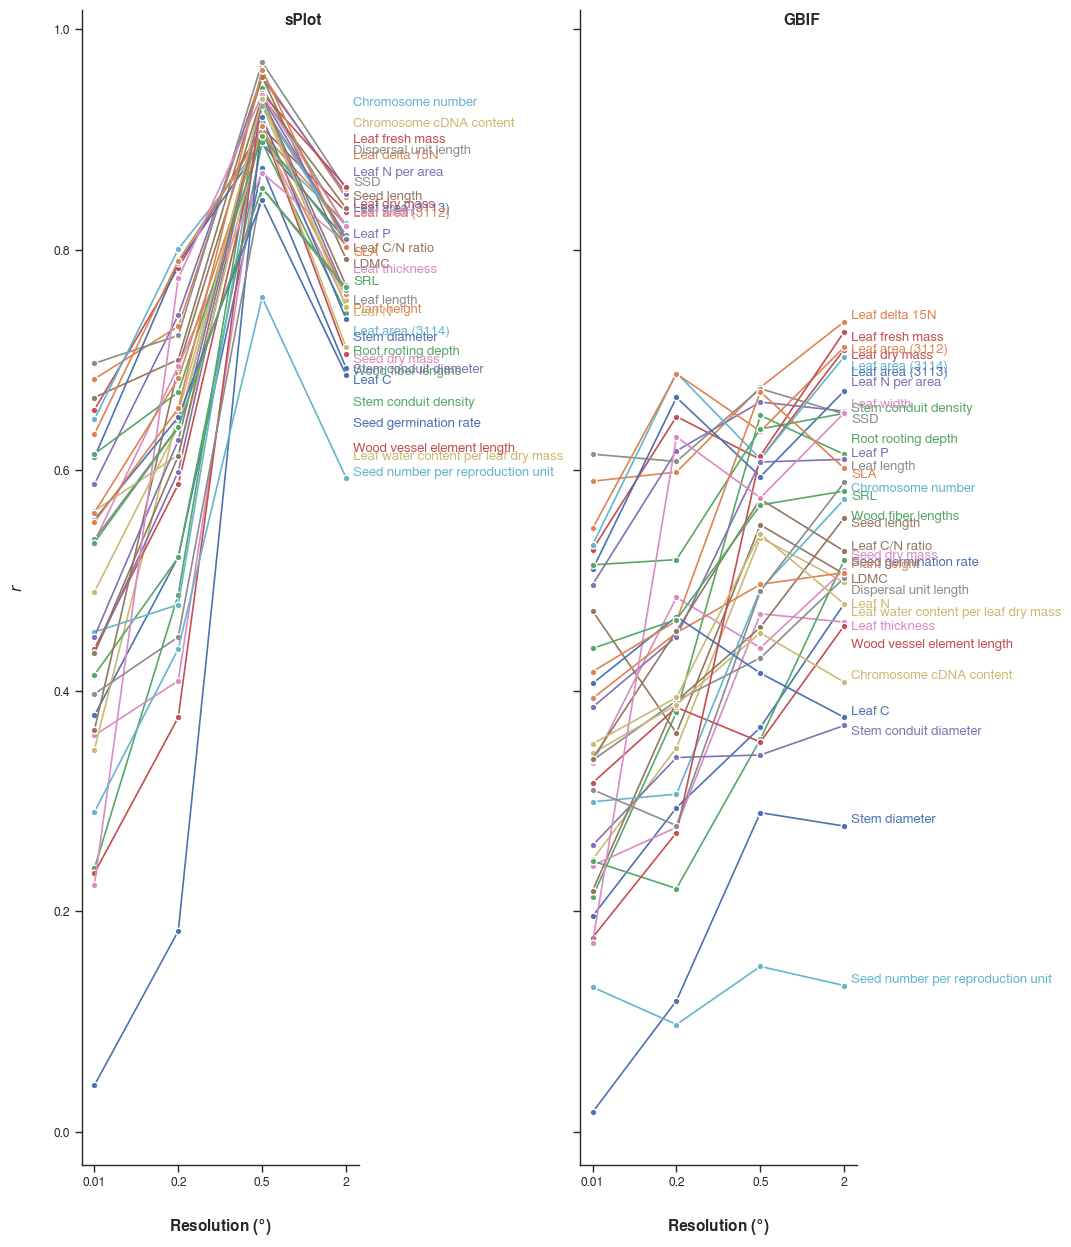

In [264]:
from typing import Any
from adjustText import adjust_text


def plot_splot_correlations(df: pd.DataFrame, pft: str, context: Any = "paper", save: bool = False):
    """Plot sPlot correlations for GBIF and sPlot extrapolations for the given PFT"""
    idx = pd.IndexSlice
    df = df.loc[idx[:, pft], :]

    # Hide the PFT index
    df.index = df.index.droplevel(1)

    # fig, axs = plt.subplots(1, 2, figsize=(20, 25), dpi=150)
    fig, axs = plt.subplots(1, 2, sharey=True)
    splot_ax = axs[0]
    gbif_ax = axs[1]

    df = df.sort_index(ascending=False)
    text_x = 0.98

    # Define colors
    # colors = plt.cm.Paired(np.linspace(0, 1, len(stg.index.get_level_values(0).unique())))
    # use sns instead (e.g. sns.hls_palette(h=.5))
    colors = sns.color_palette(n_colors=len(df.index.get_level_values(0).unique()))

    # context
    sns.set_context(context)

    with open("trait_mapping.json", "r", encoding="utf-8") as f:
        trait_mapping = json.load(f)

    x_positions = [text_x] * len(df.index.get_level_values(0).unique())

    y_positions_gbif = []
    y_positions_splot = []

    labels = []
    label_colors = []

    title_kwargs = {
    "fontweight": "bold",
    "fontsize": 11,
    "y": 0.98,
    "x": 0.8
}

    label_kwargs = {
        "fontweight": "bold",
        "fontsize": 11,
        "labelpad": 20
    }

    # Loop over each trait
    for color, trait in zip(colors, df.index.get_level_values(0).unique()):
        # Select data for the current trait
        trait_data = df.loc[trait]

        trait_short = trait_mapping[trait.split("X")[-1]]["short"]

        gbif_data = trait_data.xs("GBIF", axis=0, level=1)
        y_positions_gbif.append(gbif_data.iloc[0])
        
        splot_data = trait_data.xs("sPlot", axis=0, level=1)
        y_positions_splot.append(splot_data.iloc[0])
        
        labels.append(trait_short)
        label_colors.append(color)

        ax_params = {
            "linestyle": "-",
            "color": color,
            "marker": "o",
            "markeredgecolor": "white",
            "markeredgewidth": 1.0
        }

        splot_ax.plot(
            splot_data,
            # label=f"{trait} sPlot",
            **ax_params
        )
        splot_ax.set_ylabel("$r$", **label_kwargs)
        splot_ax.set_title("sPlot", **title_kwargs)


        gbif_ax.plot(
            gbif_data,
            # label=f"{trait} GBIF",
            **ax_params
        )
        gbif_ax.set_title("GBIF", **title_kwargs)

    texts_gbif = []
    for x_position, y_position, label, color in zip(
        x_positions, y_positions_gbif, labels, label_colors
    ):
        text = gbif_ax.text(
            x_position,
            y_position,
            label,
            color=color,
        )
        texts_gbif.append(text)

    # make sure the plots share the same y-axis
    # splot_ax.set_ylim(gbif_ax.get_ylim())

    texts_splot = []
    for x_position, y_position, label, color in zip(
        x_positions, y_positions_splot, labels, label_colors
    ):
        text = splot_ax.text(
            x_position,
            y_position,
            label,
            color=color,
        )
        texts_splot.append(text)

    adjust_text_kwargs = {
        "autoalign": "y",
        "only_move": {"text": "y", "static": "y", "explode": "y", "pull": "y"},
        "text_from_points": False,
        "precision": 0.01
    }

    adjust_text(
        texts_gbif,
        ax=gbif_ax,
        force_text=(0, 0.8),
        **adjust_text_kwargs,
    )

    adjust_text(
        texts_splot,
        ax=splot_ax,
        **adjust_text_kwargs,
        force_text=(0, 0.8),
    )

    # Readjust the x-position of the text since adjust_text doesn't seem to respect the
    # only_move parameter and still moves the text in the x-direction
    def _reset_text_x(texts, x_position, ax):
        for text in texts:
            text.set_ha("left")
            text.set_x(x_position)
            text.set_transform(ax.get_yaxis_transform())

    _reset_text_x(texts_gbif, text_x, gbif_ax)
    _reset_text_x(texts_splot, text_x, splot_ax)

    # Set labels and reverse x-axis
    for ax in axs:
        ax.set_xlabel("Resolution ($\degree$)", **label_kwargs)
        ax.invert_xaxis()

    # Show the plots
    sns.despine()

    # add space between plots
    plt.subplots_adjust(wspace=0.8)

    fig.set_figheight(15)
    fig.set_figwidth(10)

    if save:
        plt.savefig(fig_dir / "gbif-vs-splot-corr.pdf", bbox_inches="tight")
    
    plt.show()

plot_splot_correlations(corr_table, "Shrub-Tree-Grass", context="paper", save=True)

Table

In [16]:
import json


corr_stg = corr_table.copy().loc[pd.IndexSlice[:, "Shrub-Tree-Grass"], :]

with open("trait_mapping.json", "r") as f:
    trait_mapping = json.load(f)

# Add trait name column to corr_table
corr_stg["Trait name"] = corr_stg.index.map(
    lambda x: trait_mapping[x[0].split("X")[1]]["short"]
)
corr_stg = corr_stg.set_index("Trait name", append=True).droplevel(1)
corr_stg.index = corr_stg.index.droplevel(0)

corr_stg = corr_stg.sort_values(by=[("0.01", "GBIF")], ascending=False).round(2)
# Color cells in each column according to their value
corr_stg.style.background_gradient(cmap="coolwarm", axis=0)